# Import libraries and data

## Libraries

In [15]:
# Import of libraries used in project

# Data manipulation
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Forecast model
import tensorflow as tf
import pmdarima as pm
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Performance evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import randint, invgamma

# Miscellaneous
import wget
from pathlib import Path
import yfinance as yf
import datetime
from datetime import datetime, timedelta
from itertools import permutations
import os


## Fuel prices

In [28]:
# Default configuration for data visualization
%matplotlib inline
%config InlineBackend.figure_formats = ['png']


# More in https://matplotlib.org/stable/tutorials/introductory/customizing.html#matplotlib-rcparams
custom_backend_params = {
    'figure.dpi':300,
    'savefig.dpi':300
}
sns.set(rc=custom_backend_params)
sns.set_style(style='whitegrid')

In [17]:
# Download most recent file
try:
    file_name = "semanal-regioes-desde-2013.xlsx"

    file_path = Path("..", "data", "raw", f"{file_name}")
    #file_path.unlink(missing_ok=True)
    
    url = f"https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/{file_name}"
    wget.download(url, str(file_path.absolute()))

    print("Most recent file has been downloaded")
except Exception as e:
    print(f"Error while trying to get most recent file: {e}")

Most recent file has been downloaded


In [18]:
# Loading data in memory
df_fuel_prices = pd.read_excel(
    io=file_path,
    skiprows=17
)

df_fuel_prices.head()


,DATA INICIAL,DATA FINAL,REGIÃO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
0,2012-12-30,2013-01-05,CENTRO OESTE,ETANOL HIDRATADO,606,R$/l,1.962,0.182,1.650,2.449,0.314,0.093,1.648,0.146,1.41,2.057,0.089
1,2012-12-30,2013-01-05,NORDESTE,ETANOL HIDRATADO,1481,R$/l,2.191,0.117,1.850,2.720,0.248,0.053,1.943,0.118,1.62,2.2892,0.061
2,2012-12-30,2013-01-05,NORTE,ETANOL HIDRATADO,359,R$/l,2.314,0.170,1.990,3.000,0.267,0.073,2.047,0.121,1.6239,2.29,0.059
3,2012-12-30,2013-01-05,SUDESTE,ETANOL HIDRATADO,4236,R$/l,1.885,0.230,1.479,2.749,0.259,0.122,1.626,0.199,1.2995,2.3632,0.122
4,2012-12-30,2013-01-05,SUL,ETANOL HIDRATADO,1491,R$/l,2.084,0.230,1.739,2.770,0.249,0.110,1.835,0.198,1.5,2.2877,0.108


In [19]:
# Changing labels to use it directly in plots
df_fuel_prices.replace(
    {
        "NORTE": "Norte",
        "NORDESTE": "Nordeste",
        "CENTRO OESTE": "Centro-Oeste",
        "SUDESTE": "Sudeste",
        "SUL": "Sul",

        "ETANOL HIDRATADO": "Etanol Hidratado",
        "GASOLINA COMUM": "Gasolina Comum",
        "GASOLINA ADITIVADA": "Gasolina Aditivada",
        "OLEO DIESEL": "Óleo Diesel",
        "OLEO DIESEL S10": "Óleo Diesel S10",
        "GLP": "GLP",
        "GNV": "GNV",

        "R$/m3": "R$/m³",
        "R$/13Kg": "R$/13kg"
    },
    inplace=True
)

df_fuel_prices.head(3)

,DATA INICIAL,DATA FINAL,REGIÃO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
0,2012-12-30,2013-01-05,Centro-Oeste,Etanol Hidratado,606,R$/l,1.962,0.182,1.65,2.449,0.314,0.093,1.648,0.146,1.41,2.057,0.089
1,2012-12-30,2013-01-05,Nordeste,Etanol Hidratado,1481,R$/l,2.191,0.117,1.85,2.720,0.248,0.053,1.943,0.118,1.62,2.2892,0.061
2,2012-12-30,2013-01-05,Norte,Etanol Hidratado,359,R$/l,2.314,0.170,1.99,3.000,0.267,0.073,2.047,0.121,1.6239,2.29,0.059


## USD convertion to BRL

In [20]:
# Getting USD convertion to BRL in same period of fuel prices
min_date = df_fuel_prices["DATA FINAL"].min()
min_date = (min_date - timedelta(days=7)).strftime("%Y-%m-%d")

s_usdbrl = yf.Ticker("USDBRL=X").history(start=min_date)["Close"]

max_date = s_usdbrl.index.max().strftime("%Y-%m-%d")

date_index = pd.date_range(min_date, max_date, freq="D", inclusive="both")


df_usdbrl = s_usdbrl\
    .reindex(index=date_index, method="ffill")\
    .reset_index()\
    .rename({"index": "Date"}, axis="columns")\
    .dropna()

df_usdbrl.tail()

,Date,Close
3581,2022-10-19,5.2398
3582,2022-10-20,5.2692
3583,2022-10-21,5.2166
3584,2022-10-22,5.2166
3585,2022-10-23,5.1643


## Brent oil in USD

In [21]:
# Getting Brent crude oil price in USD
s_brent_crude_oil = yf.Ticker("BZ=F").history(start=min_date)["Close"]

max_date = s_brent_crude_oil.index.max().strftime("%Y-%m-%d")

date_index = pd.date_range(min_date, max_date, freq="D", inclusive="both")


df_brent_crude_oil = s_brent_crude_oil\
    .reindex(index=date_index, method="ffill")\
    .reset_index()\
    .rename({"index": "Date"}, axis="columns")\
    .dropna()

df_brent_crude_oil.tail()

,Date,Close
3579,2022-10-17,91.620003
3580,2022-10-18,90.029999
3581,2022-10-19,92.410004
3582,2022-10-20,92.379997
3583,2022-10-21,93.500000


# Exploratory data analysis

In [22]:
products_list = df_fuel_prices['PRODUTO'].unique()
products_list.sort()

df_main_informations = pd.DataFrame(data={
    "Nome do produto": [],
    "Data do primeiro registro": [],
    "Data do último registro": [],
    "Preço mínimo": [],
    "Preço máximo": []
})

print("Main informations by products\n")


for product in products_list:
    # print(f'{product} information:')
    df_product = df_fuel_prices.query(f"PRODUTO == '{product}'")[['DATA INICIAL', 'DATA FINAL', 'PREÇO MÉDIO REVENDA']]

    df_main_informations = pd.concat([
        df_main_informations,
        pd.DataFrame(data={
            "Nome do produto": [product],
            "Data do primeiro registro": [df_product['DATA FINAL'].dt.date.min()],
            "Data do último registro": [df_product['DATA FINAL'].dt.date.max()],
            "Preço mínimo": [df_product['PREÇO MÉDIO REVENDA'].min()],
            "Preço máximo": [df_product['PREÇO MÉDIO REVENDA'].max()]
            })
    ], 
    ignore_index=True)


df_main_informations

Main informations by products



,Nome do produto,Data do primeiro registro,Data do último registro,Preço mínimo,Preço máximo
0,Etanol Hidratado,2013-01-05,2022-09-17,1.800,6.050
1,GLP,2013-01-05,2022-09-17,38.056,123.906
2,GNV,2013-01-05,2022-09-17,1.645,7.090
3,Gasolina Aditivada,2020-10-24,2022-09-17,4.406,7.870
4,Gasolina Comum,2013-01-05,2022-09-17,2.724,7.710
5,Óleo Diesel,2013-01-05,2022-09-17,2.102,7.860
6,Óleo Diesel S10,2013-01-05,2022-09-17,2.164,7.840


The product "Gasolina Aditivada" will be removed of analysis because there is no sufficient data compared to other products.

In [23]:
df_fuel_prices = df_fuel_prices.query("PRODUTO != 'Gasolina Aditivada'")

products_list = df_fuel_prices['PRODUTO'].unique()
products_list.sort()

regions_list = df_fuel_prices['REGIÃO'].unique()
regions_list.sort()

Average fuel price by region and product


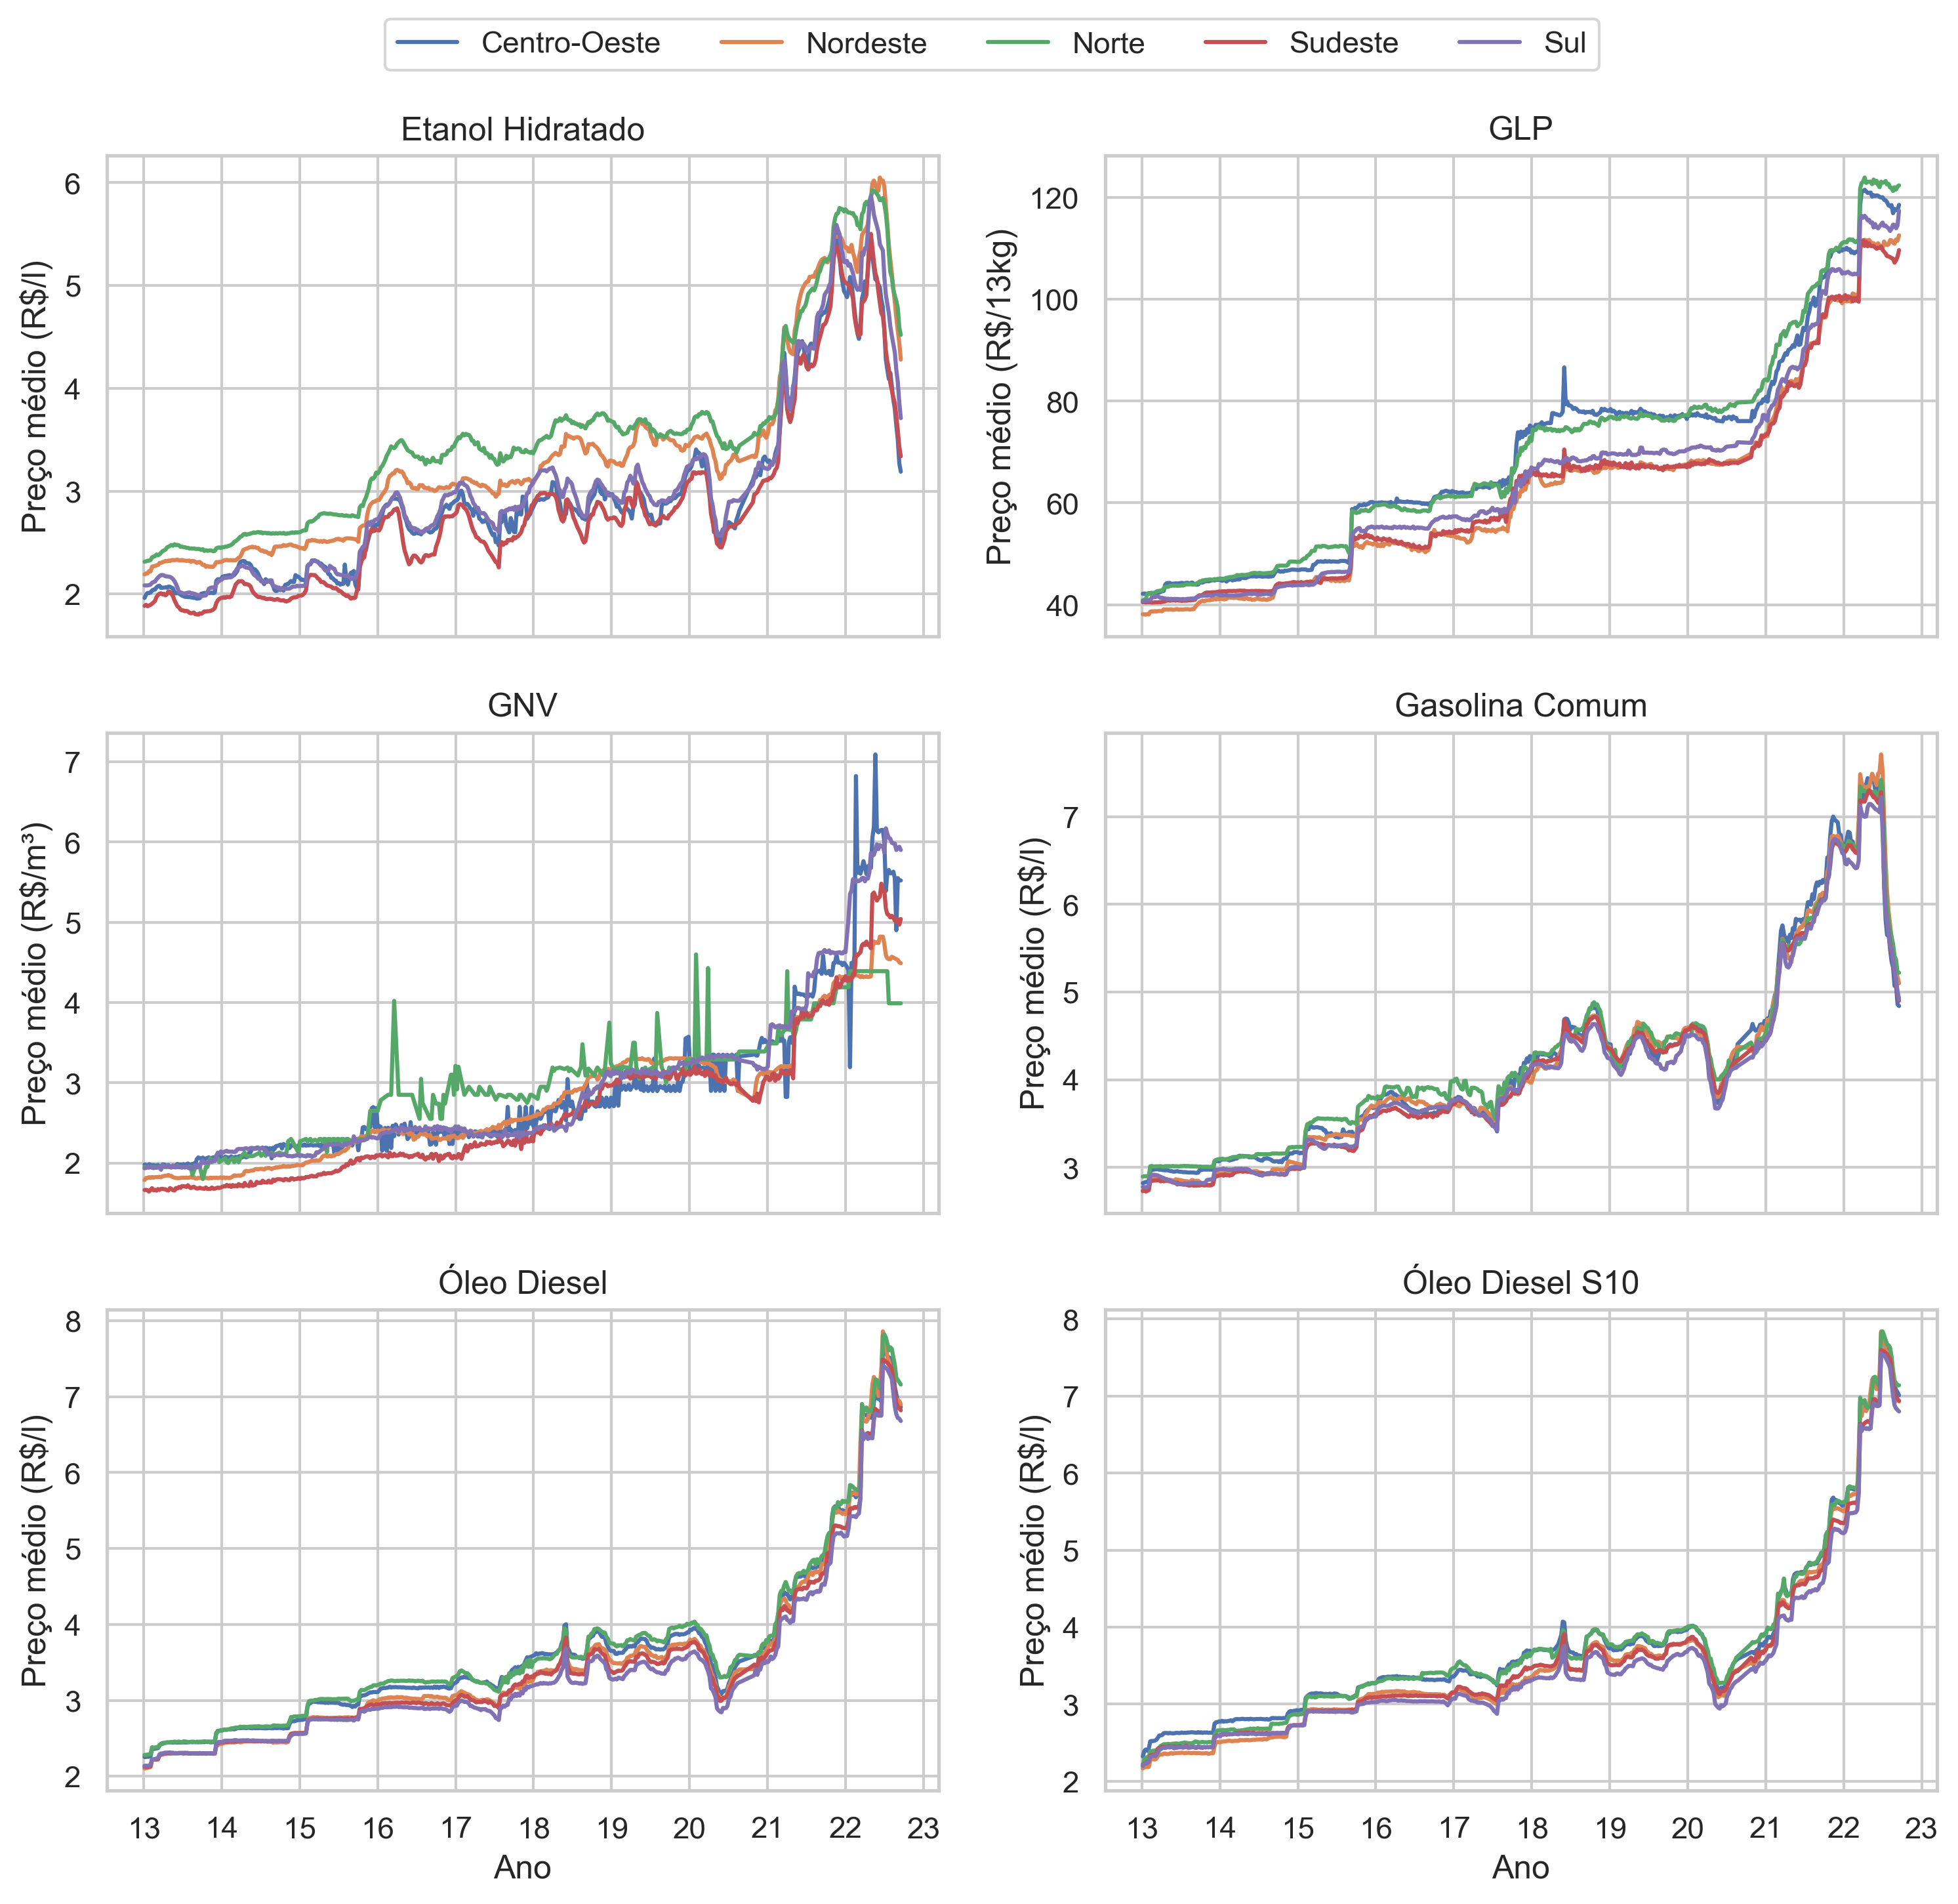

In [30]:
# Plot of all fuels and regions in file
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 11),
    sharex=True
)

for (i, product), ax in zip(enumerate(products_list), axes.ravel()):
    sns.lineplot(
        data=df_fuel_prices.query(f"PRODUTO == '{product}'"),
        x='DATA FINAL',
        y='PREÇO MÉDIO REVENDA',
        hue='REGIÃO',
        ax=ax
    )

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            loc='upper center',
            ncol=len(handles),
            bbox_to_anchor=(0.5, 0.95)
        )

    ax.get_legend().remove()
    ax.set_title(f'{product}')

    unit_measure = df_fuel_prices.loc[df_fuel_prices['PRODUTO']==product, 'UNIDADE DE MEDIDA'].unique()[0]
    ax.set_ylabel(f'Preço médio ({unit_measure})')
    ax.set_xlabel("Ano")

    # Define the date format
    ax.xaxis.set_major_formatter(DateFormatter("%y"))

print("Average fuel price by region and product")

fig.savefig(Path("..", "results", "grafico_historico_preco_combustiveis.pdf"), bbox_inches="tight")

plt.show()

## Visited gas stations per product during data gathering

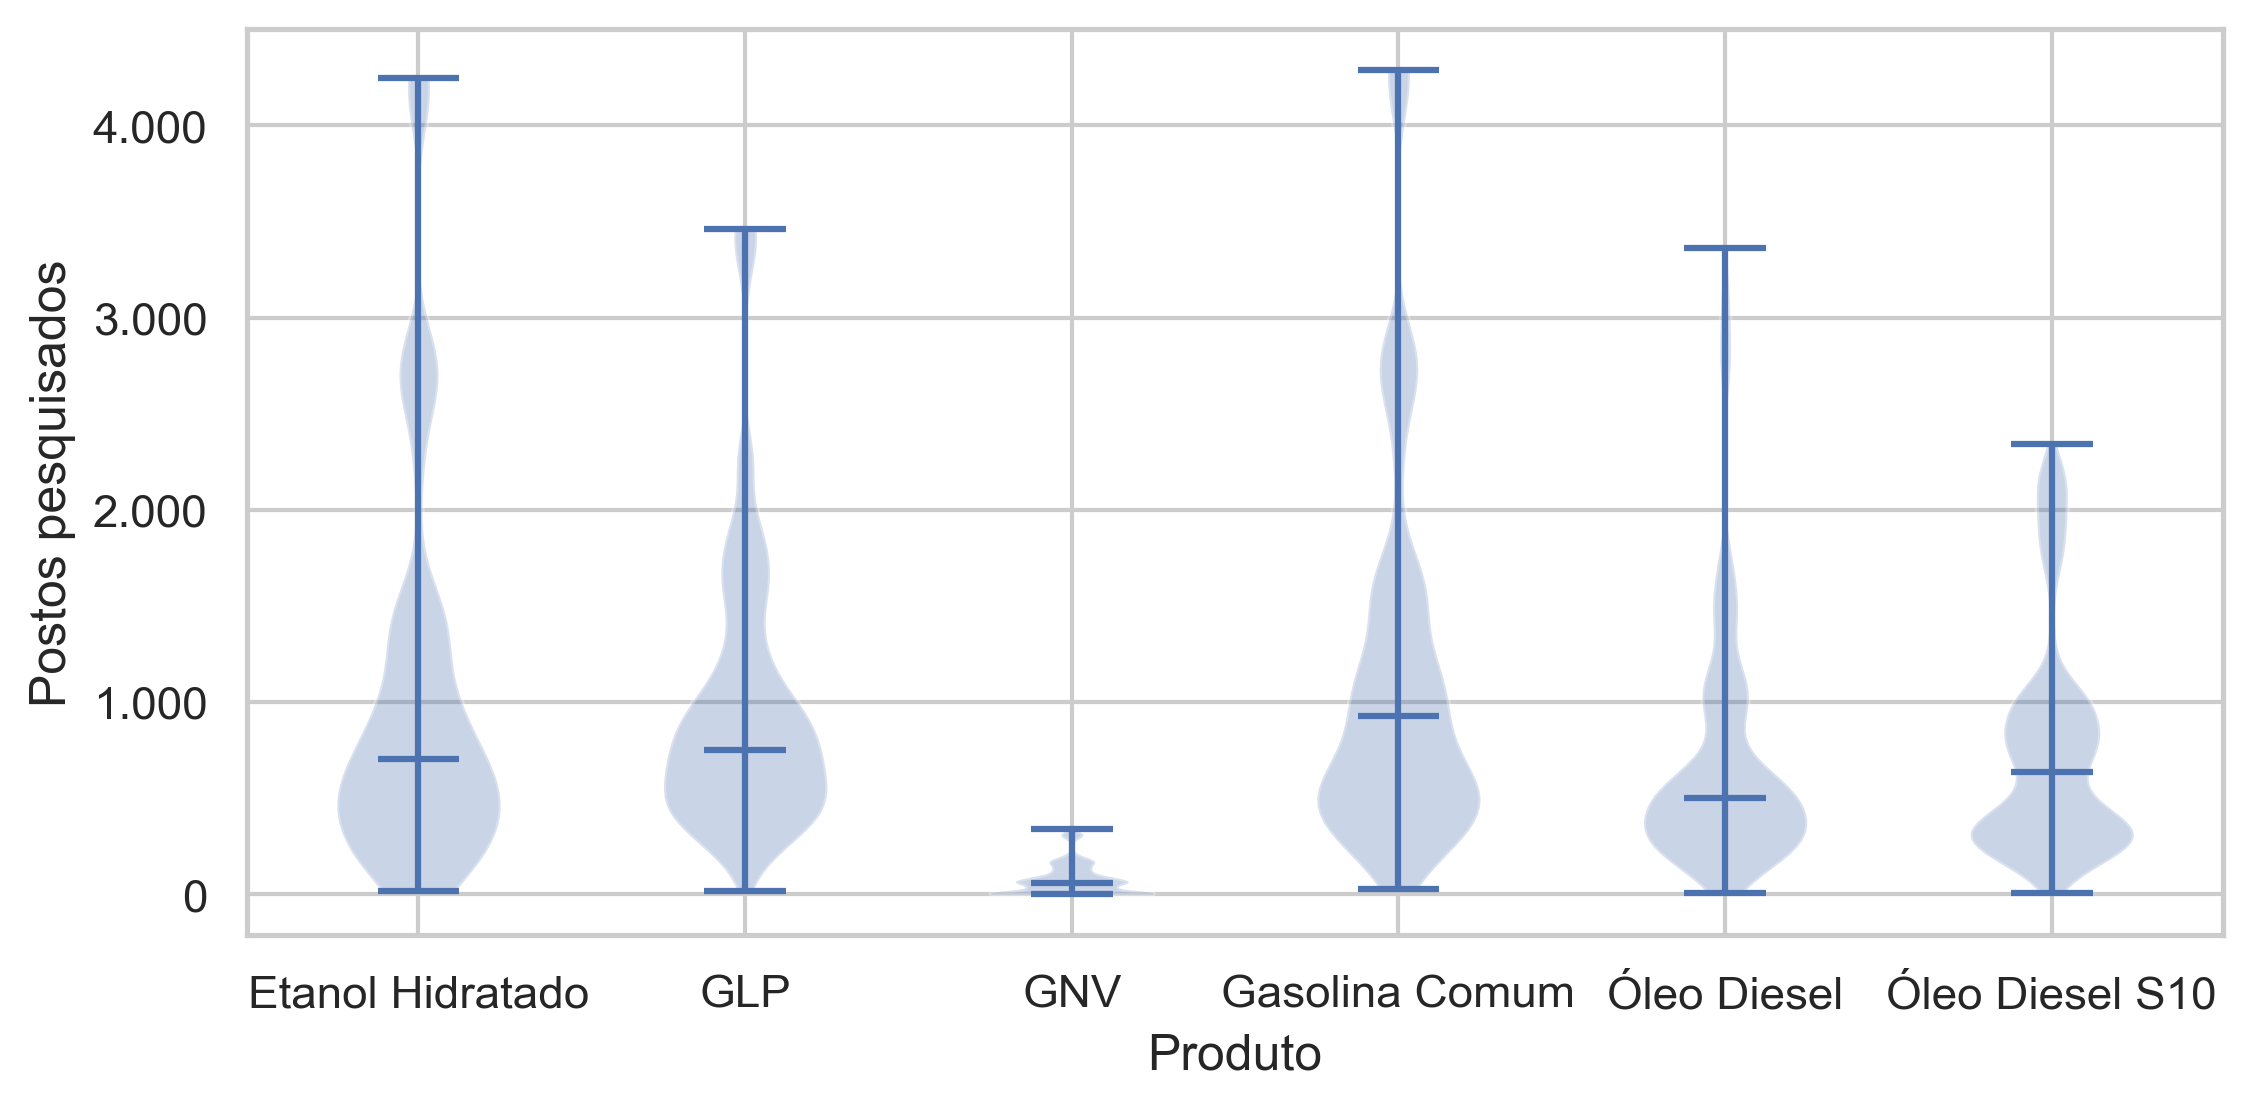

In [31]:
list_gas_station = []
for product in products_list:
    list_gas_station.append(df_fuel_prices.loc[df_fuel_prices["PRODUTO"] == product, "NÚMERO DE POSTOS PESQUISADOS"].tolist())


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 4))



ax.violinplot(
    list_gas_station,
    showmeans=False,
    showmedians=True,
    vert=True
)
# ax.set_title('Violin plot')
ax.yaxis.grid(True)

ax.set_xticks([y + 1 for y in range(len(list_gas_station))])
ax.set_xticklabels(labels=products_list)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',').replace(",", ".")))

ax.set_xlabel('Produto')
ax.set_ylabel('Postos pesquisados')

fig.savefig(Path("..", "results", "postos_pesquisados_por_produto.pdf"), bbox_inches="tight")

plt.show()

## Treatment of missing values of time series

In [36]:
# Replace missing values of time series with last valide value
df_complete_fuel_prices = pd.DataFrame(columns=['DATA FINAL', 'REGIÃO', 'PRODUTO', 'PREÇO MÉDIO REVENDA'])
df_missing_fuel_prices = pd.DataFrame(columns=['DATA FINAL', 'REGIÃO', 'PRODUTO'])

for product in products_list:
    for region in regions_list:
        df_temp = df_fuel_prices\
            .loc[(df_fuel_prices['REGIÃO']==region) & (df_fuel_prices['PRODUTO']==product), ['DATA FINAL', "PREÇO MÉDIO REVENDA"]]\
            .sort_values(by='DATA FINAL', ascending=True, ignore_index=True)

        min_date = df_temp['DATA FINAL'].min().strftime("%Y-%m-%d")
        max_date = df_temp['DATA FINAL'].max().strftime("%Y-%m-%d")

        date_index = pd.date_range(min_date, max_date, freq="7D", inclusive="both")

        new_dates = date_index.to_series().loc[~date_index.to_series().isin(df_temp["DATA FINAL"])]
        if len(new_dates) > 0:
            df_missing_fuel_prices = pd.concat([
                df_missing_fuel_prices,
                pd.DataFrame({
                    'DATA FINAL': new_dates,
                    'REGIÃO': region,
                    'PRODUTO': product
                })
            ])

        df_temp = df_temp\
            .set_index("DATA FINAL")\
            .reindex(index=date_index, method="ffill")\
            .reset_index()\
            .rename({"index": "DATA FINAL"}, axis="columns")
        
        df_complete_fuel_prices = pd.concat([
            df_complete_fuel_prices,
            pd.DataFrame({
                'DATA FINAL': df_temp["DATA FINAL"],
                'REGIÃO': region,
                'PRODUTO': product,
                'PREÇO MÉDIO REVENDA': df_temp["PREÇO MÉDIO REVENDA"]
            })
        ])

## Decompose of time series

In [37]:
# Decompose of time series to analyse trend, seasonality and residuals
df_fuel_prices_decomp = pd.DataFrame(columns=['DATA FINAL', 'REGIÃO', 'PRODUTO', 'MÉTRICA', 'VALOR'])
for product in products_list:
    for region in regions_list:
        df_time_series = df_complete_fuel_prices\
            .loc[(df_complete_fuel_prices['REGIÃO']==region) & (df_complete_fuel_prices['PRODUTO']==product),
                ['PREÇO MÉDIO REVENDA', 'DATA FINAL']]\
            .set_index('DATA FINAL')
        df_time_series.sort_index(inplace=True)

        df_decomp = seasonal_decompose(df_time_series, model='additive', period=51)
        observed = df_decomp.observed.reset_index()
        trend = df_decomp.trend.reset_index()
        seasonal = df_decomp.seasonal.reset_index()
        resid = df_decomp.resid.reset_index()

        df_fuel_prices_decomp = pd.concat(
            [
                df_fuel_prices_decomp,
                pd.DataFrame({
                    'DATA FINAL': observed.iloc[:, 0],
                    'REGIÃO': region,
                    'PRODUTO': product,
                    'MÉTRICA': 'Observado',
                    'VALOR': observed.iloc[:, 1],
                }),
                pd.DataFrame({
                    'DATA FINAL': trend.iloc[:, 0],
                    'REGIÃO': region,
                    'PRODUTO': product,
                    'MÉTRICA': 'Tendência',
                    'VALOR': trend.iloc[:, 1],
                }),
                pd.DataFrame({
                    'DATA FINAL': seasonal.iloc[:, 0],
                    'REGIÃO': region,
                    'PRODUTO': product,
                    'MÉTRICA': 'Sazonalidade',
                    'VALOR': seasonal.iloc[:, 1],
                }),
                pd.DataFrame({
                    'DATA FINAL': resid.iloc[:, 0],
                    'REGIÃO': region,
                    'PRODUTO': product,
                    'MÉTRICA': 'Resíduo',
                    'VALOR': resid.iloc[:, 1],
                })
            ]
        )

df_fuel_prices_decomp.reset_index(inplace=True)

In [ ]:
# Plotting observed, trend, seasonal and residuals data

product = 'Óleo Diesel'

fig, axes = plt.subplots(
    ncols=1,
    nrows=4,
    figsize=(7, 8),
    sharex=True
)

metrics_list = ['Observado', 'Tendência', 'Sazonalidade', 'Resíduo']

for metric, ax in zip(metrics_list, axes.ravel()):
    sns.lineplot(
        data=df_fuel_prices_decomp.query(f"PRODUTO == '{product}' and MÉTRICA == '{metric}'"),
        x='DATA FINAL',
        y='VALOR',
        hue='REGIÃO',
        ax=ax
    )

    if metric == 'Observado':
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            loc='upper center',
            ncol= 3,#len(handles),
            bbox_to_anchor=(0.5, 0.98)
        )

    if metric in ("Sazonalidade", "Resíduo"):
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: f"{x:.2f}".replace(".", ",")))

    ax.set_ylabel("Valor")

    ax.get_legend().remove()
    ax.set_title(f'{metric}')
    ax.set_xlabel("Ano")
    ax.xaxis.set_major_formatter(DateFormatter("%y"))
    # unit_measure = df_fuel_prices.loc[df_fuel_prices['PRODUTO']==product, 'UNIDADE DE MEDIDA'].unique()[0]
    # ax.set_ylabel(f'PREÇO MÉDIO ({unit_measure})')

    fig.savefig(Path("..", "results", "decomposicao_preco_oleo_diesel.pdf"), bbox_inches="tight")

    plt.show()

# Forecast models

In [40]:
# DataFrame with error metrics
df_errors = pd.DataFrame(
    data={
        "Modelo": [],
        "MSE": [],
        "RMSE": [],
        "MAE": []
    }
)

In [41]:
# Product and region choosed for forecasting model training
fuel_type = 'Óleo Diesel'
region = 'Sudeste'

# Setting date boudaries
train_date_begin = pd.to_datetime("2013-01-05")
train_date_end = pd.to_datetime("2022-05-07")

test_input_date_begin = pd.to_datetime("2022-05-14")
test_input_date_end = pd.to_datetime("2022-07-02")

test_output_date_begin = pd.to_datetime("2022-07-09")
test_output_date_end = pd.to_datetime("2022-08-27")

# train_date_limit = pd.to_datetime('2022-02-28')
# test_date_limit = pd.to_datetime('2022-08-31') # will be used 6 full months of data for test

In [42]:
# Dataset to be used in all models
df = df_complete_fuel_prices.query(f"PRODUTO == '{fuel_type}' & REGIÃO == '{region}'")

df = df\
    .merge(df_brent_crude_oil, left_on="DATA FINAL", right_on="Date", how="left")\
    .drop(columns="Date")\
    .rename(columns={"Close": "BrentOilPrice"})\
    .merge(df_usdbrl, left_on="DATA FINAL", right_on="Date", how="left")\
    .drop(columns=["Date", "REGIÃO", "PRODUTO"])\
    .rename(columns={
        "DATA FINAL": "Date",
        "REGIÃO": "Region",
        "PRODUTO": "Product",
        "PREÇO MÉDIO REVENDA": "FuelPrice",
        "Close": "USDBRLPrice"
        })

df["DataType"] = np.select(
    [
        df.Date.between(train_date_begin, train_date_end, inclusive="both"),
        df.Date.between(test_input_date_begin, test_input_date_end, inclusive="both"),
        df.Date.between(test_output_date_begin, test_output_date_end, inclusive="both")],
    ["Train", "Input Test", "Output Test"],
    default="Drop"
)

df = df[df.DataType != "Drop"]

df.sort_values(by="Date", ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

dict_int_dates = {i: date for i, date in enumerate(df.Date)}
dict_dates_int = {date: i for i, date in enumerate(df.Date)}

df_train = df[df.DataType == "Train"]
df_test = df[df.DataType != "Train"]

print("Train dataset:")
display(df_train.iloc[np.append(np.arange(0, 5), np.arange(-5, 0))])

print("\nTest dataset:")
display(df_test.iloc[np.append(np.arange(0, 5), np.arange(-5, 0))])

Train dataset:


,Date,FuelPrice,BrentOilPrice,USDBRLPrice,DataType
0,2013-01-05,2.125,111.309998,2.0487,Train
1,2013-01-12,2.125,110.639999,2.0277,Train
2,2013-01-19,2.121,110.610001,2.0371,Train
3,2013-01-26,2.126,113.279999,2.0285,Train
4,2013-02-02,2.132,116.760002,1.9906,Train
483,2022-04-09,6.512,102.779999,4.7521,Train
484,2022-04-16,6.522,111.699997,4.7010,Train
485,2022-04-23,6.514,106.650002,4.6208,Train
486,2022-04-30,6.512,109.339996,4.9378,Train
487,2022-05-07,6.496,112.389999,5.0280,Train



Test dataset:


,Date,FuelPrice,BrentOilPrice,USDBRLPrice,DataType
488,2022-05-14,6.71,111.550003,5.1334,Input Test
489,2022-05-21,6.84,112.550003,4.9300,Input Test
490,2022-05-28,6.82,119.430000,4.7682,Input Test
491,2022-06-04,6.81,119.720001,4.7957,Input Test
492,2022-06-11,6.79,122.010002,4.9033,Input Test
499,2022-07-30,7.40,110.010002,5.1827,Output Test
500,2022-08-06,7.36,94.919998,5.2111,Output Test
501,2022-08-13,7.22,98.150002,5.1570,Output Test
502,2022-08-20,7.05,96.720001,5.1670,Output Test
503,2022-08-27,6.92,100.989998,5.1087,Output Test


## SARIMA

In [43]:
# Find best parameters to use in model
stepwise_fit = pm.auto_arima(
    y=df_train.FuelPrice,
    seasonal=True,
    stationary=False,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    start_d=0, max_d=5,
    start_P=0, max_P=5,
    start_Q=0, max_Q=5,
    start_D=0, max_D=5,
    m=52,
    stepwise=True, # if False will perform a grid search instead
    random=False,
    trace=False,    
    maxiter=200
)

# SARIMA parameters
p = stepwise_fit.order[0]
d = stepwise_fit.order[1]
q = stepwise_fit.order[2]
P = stepwise_fit.seasonal_order[0]
D = stepwise_fit.seasonal_order[1]
Q = stepwise_fit.seasonal_order[2]
m = stepwise_fit.seasonal_order[3]


print(f"""
Best parameters for input data:\n
SARIMA(p,d,q)(P,D,Q)m = SARIMA({p},{d},{q})({P},{D},{Q}){m}
""")


Best parameters for input data:

SARIMA(p,d,q)(P,D,Q)m = SARIMA(0,2,2)(0,0,0)52



In [44]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  488
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 711.088
Date:                Sun, 23 Oct 2022   AIC                          -1416.175
Time:                        21:51:38   BIC                          -1403.617
Sample:                             0   HQIC                         -1411.241
                                - 488                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8704      0.017    -50.928      0.000      -0.904      -0.837
ma.L2         -0.1005      0.025     -4.019      0.000      -0.150      -0.052
sigma2         0.0031    3.2e-05     97.522      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            266922.25
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              20.63   Skew:                             7.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Pass calculated parameters to fit SARIMA model
sarima_model =\
    pm.ARIMA(
        order=stepwise_fit.order,
        seasonal_order=stepwise_fit.seasonal_order)\
    .fit(
        y=df_train.FuelPrice
    )

sarima_result = sarima_model.predict(
    n_periods= len(df_test)
)

df_test.loc[df_test.index, ["SARIMAResult"]] = pd.Series(index=df_test.index, data=sarima_result)

df_test.iloc[np.append(np.arange(0, 5), np.arange(-5, 0))]


,Date,FuelPrice,BrentOilPrice,USDBRLPrice,DataType,SARIMAResult
488,2022-05-14,6.71,111.550003,5.1334,Input Test,6.530125
489,2022-05-21,6.84,112.550003,4.9300,Input Test,6.571002
490,2022-05-28,6.82,119.430000,4.7682,Input Test,6.611955
491,2022-06-04,6.81,119.720001,4.7957,Input Test,6.652983
492,2022-06-11,6.79,122.010002,4.9033,Input Test,6.694086
499,2022-07-30,7.40,110.010002,5.1827,Output Test,6.983916
500,2022-08-06,7.36,94.919998,5.2111,Output Test,7.025621
501,2022-08-13,7.22,98.150002,5.1570,Output Test,7.067402
502,2022-08-20,7.05,96.720001,5.1670,Output Test,7.109258
503,2022-08-27,6.92,100.989998,5.1087,Output Test,7.151189


In [21]:
# Plot results for SARIMA model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_train[df_train.Date >= "2018-01-01"],
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="SARIMAResult")

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Ano')
axes.legend(['Treino', 'Teste', 'Previsto (ARIMA)'])

# plt.savefig('Resultados modelo SARIMA.png', dpi=200, bbox_inches="tight")

plt.show()

<Figure size 1800x1200 with 1 Axes>

In [22]:
# Get SARIMA model errors
mse = mean_squared_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["SARIMAResult"]])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["SARIMAResult"]])

# And insert them into df_errors
try:
    model_index=  df_errors[df_errors.Modelo == "SARIMA"].index[0]
    
    df_errors.at[model_index, "MSE"] = mse
    df_errors.at[model_index, "RMSE"] = rmse
    df_errors.at[model_index, "MAE"] = mae
    
except (IndexError, AttributeError):
    df_errors = pd.concat([
        df_errors,
        pd.DataFrame(data={
            "Modelo": ["SARIMA"],
            "MSE": [mse],
            "RMSE": [rmse],
            "MAE": [mae]
        })],
        ignore_index=True
    )

print(f'Métricas de erro para o período de teste ({len(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]])} semanas):')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')
print(f'MAE = {mae}')

Métricas de erro para o período de teste (8 semanas):
MSE = 0.15699848467434224
RMSE = 0.39623034295008536
MAE = 0.3526550197198379


## SARIMAX

In [23]:
# Find best parameters to use in model
stepwise_fit = pm.auto_arima(
    y=df_train.FuelPrice,
    X=df_train[["BrentOilPrice", "USDBRLPrice"]],
    seasonal=True,
    stationary=False,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    start_d=0, max_d=5,
    start_P=0, max_P=5,
    start_Q=0, max_Q=5,
    start_D=0, max_D=5,
    m=52,
    stepwise=True, # if False will perform a grid search instead
    random=False,
    trace=False,    
    maxiter=200
)

# SARIMAX parameters
p = stepwise_fit.order[0]
d = stepwise_fit.order[1]
q = stepwise_fit.order[2]
P = stepwise_fit.seasonal_order[0]
D = stepwise_fit.seasonal_order[1]
Q = stepwise_fit.seasonal_order[2]
m = stepwise_fit.seasonal_order[3]


print(f"""
Best parameters for input data:\n
SARIMA(p,d,q)(P,D,Q)m = SARIMA({p},{d},{q})({P},{D},{Q}){m}
""")


Best parameters for input data:

SARIMA(p,d,q)(P,D,Q)m = SARIMA(1,1,0)(0,0,0)52



In [24]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  488
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 712.434
Date:                Sat, 22 Oct 2022   AIC                          -1414.867
Time:                        13:51:48   BIC                          -1393.926
Sample:                             0   HQIC                         -1406.640
                                - 488                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0078      0.004      1.888      0.059      -0.000       0.016
BrentOilPrice    -0.0008      0.001     -0.711      0.477      -0.003       0.001
USDBRLPrice      -0.0276      0.031     -0.902      0.367      -0.088       0.032
ar.L1             0.1442      0.022      6.478      0.000       0.101       0.188
sigma2            0.0031    4.9e-05     64.053      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            288193.68
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              19.88   Skew:                             7.34
Prob(H) (two-sided):                  0.00   Kurtosis:                       121.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Pass calculated parameters to fit SARIMAX model
sarimax_model =\
    pm.ARIMA(
        order=stepwise_fit.order,
        seasonal_order=stepwise_fit.seasonal_order)\
    .fit(
        y=df_train.FuelPrice,
        X=df_train[["BrentOilPrice", "USDBRLPrice"]]
    )

sarimax_result = sarimax_model.predict(
    n_periods= len(df_test),
    X=df_test[["BrentOilPrice", "USDBRLPrice"]]
)

df_test.loc[df_test.index, ["SARIMAXResult"]] = pd.Series(index=df_test.index, data=sarimax_result)

df_test.iloc[np.append(np.arange(0, 5), np.arange(-5, 0))]

c:\Users\Henrique\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:227: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
c:\Users\Henrique\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:231: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index = pd.Int64Index(self._index.tolist() + [value])
c:\Users\Henrique\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:227: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
c:\Users\Henrique\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:231: FutureWarning: pandas.Int64Inde

,Date,FuelPrice,BrentOilPrice,USDBRLPrice,DataType,SARIMAResult,SARIMAXResult
488,2022-05-14,6.71,111.550003,5.1334,Input Test,6.530125,6.499914
489,2022-05-21,6.84,112.550003,4.9300,Input Test,6.571002,6.513491
490,2022-05-28,6.82,119.430000,4.7682,Input Test,6.611955,6.521855
491,2022-06-04,6.81,119.720001,4.7957,Input Test,6.652983,6.529997
492,2022-06-11,6.79,122.010002,4.9033,Input Test,6.694086,6.534429
499,2022-07-30,7.40,110.010002,5.1827,Output Test,6.983916,6.599643
500,2022-08-06,7.36,94.919998,5.2111,Output Test,7.025621,6.619342
501,2022-08-13,7.22,98.150002,5.1570,Output Test,7.067402,6.627537
502,2022-08-20,7.05,96.720001,5.1670,Output Test,7.109258,6.637466
503,2022-08-27,6.92,100.989998,5.1087,Output Test,7.151189,6.644994


In [26]:
# Plot results for SARIMA model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_train,
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="SARIMAXResult")

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Ano')
axes.legend(['Treino', 'Teste', 'Previsto (SARIMAX)'])

plt.show()

<Figure size 1800x1200 with 1 Axes>

In [27]:
# Get SARIMAX model errors
mse = mean_squared_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["SARIMAXResult"]])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["SARIMAXResult"]])

# And insert them into df_errors
try:
    model_index=  df_errors[df_errors.Modelo == "SARIMAX"].index[0]
    
    df_errors.at[model_index, "MSE"] = mse
    df_errors.at[model_index, "RMSE"] = rmse
    df_errors.at[model_index, "MAE"] = mae
    
except (IndexError, AttributeError):
    df_errors = pd.concat([
        df_errors,
        pd.DataFrame(data={
            "Modelo": ["SARIMAX"],
            "MSE": [mse],
            "RMSE": [rmse],
            "MAE": [mae]
        })],
        ignore_index=True
    )

print(f'Métricas de erro para o período de teste (últimas {len(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]])} semanas):')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')
print(f'MAE = {mae}')

Métricas de erro para o período de teste (últimas 8 semanas):
MSE = 0.503271399443479
RMSE = 0.7094162384971738
MAE = 0.6765599646108227


## LSTM

In [28]:
# Create function to split time series into inputs and targets using moving-window technique
def split_inputs_targets(time_series_array, input_size=1, target_size=1, shift_size=1):
    if len(time_series_array) < input_size + target_size:
        raise ValueError("Time series array must have at least (input_size + target_size) size.")

    windowed_array_view = np.lib.stride_tricks.sliding_window_view(time_series_array, input_size+target_size)

    for step_array in np.arange(start=0, stop=windowed_array_view.shape[0], step=shift_size):
        try:
            inputs = np.vstack((inputs, windowed_array_view[step_array][:input_size].T))
            targets = np.vstack((targets, windowed_array_view[step_array][input_size:].T))
        except NameError:
            inputs = windowed_array_view[step_array][:input_size].T
            targets = windowed_array_view[step_array][input_size:].T

            print(f"input shape: {inputs.shape}\ntarget shape: {targets.shape}\n")

    return inputs, targets, windowed_array_view

In [29]:
# Choose time shift and windows sizes to use in dataset for LSTM training and test
input_size = df_test.loc[df_test.DataType == "Input Test"].shape[0]
target_size = df_test.loc[df_test.DataType == "Output Test"].shape[0]
shift_size = 1

# Initialize and fit scaler (with train data) to tranform data in [0 , 1] range
scaler_train_x =  MinMaxScaler()
scaler_train_x.fit(df_train.FuelPrice.to_numpy().reshape(-1, 1))

# Calcule scaled fuel prices
df_train.loc[df_train.index, "ScaledFuelPrice"] = scaler_train_x.transform(df_train.FuelPrice.to_numpy().reshape(-1, 1))

# Create separated datasets for inputs and targets to train LSTM
lstm_train_inputs, lstm_train_targets, _ = split_inputs_targets(
    df_train.ScaledFuelPrice.to_numpy(),
    input_size,
    target_size,
    shift_size
)

input shape: (8,)
target shape: (8,)



C:\Users\Henrique\AppData\Local\Temp/ipykernel_26464/456867324.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[df_train.index, "ScaledFuelPrice"] = scaler_train_x.transform(df_train.FuelPrice.to_numpy().reshape(-1, 1))


In [30]:
# # Generate all permutations of layers and neurons in two ranges each
# n_layers = [x for x in range(1, 6, 2)]
# n_neurons = [x for x in range(4, 133, 16)]
# layers_combination = []
# for layers in n_layers:
#     layers_combination.extend(list(permutations(n_neurons, layers)))

# if len(layers_combination) < 200:
#     print(f"{len(layers_combination)} possible permutations: \n{layers_combination}")
# else:
#     print(f"{len(layers_combination)} possible permutations")


In [31]:
neurons_and_dropout_list = []
for _ in range(0, 10):
    layers_size = randint.rvs(low=1, high=50, size=1)[0]
    neurons_and_dropout_list.append(list(zip(randint.rvs(low=1, high=100, size=layers_size), map(lambda x: min(0.95, x), invgamma.rvs(a=3, size=layers_size, scale=0.5)))))

neurons_and_dropout_list[0:min(len(neurons_and_dropout_list), 3)]

[[(82, 0.27272881837816926),
  (23, 0.21526291818667873),
  (41, 0.4976105373846135),
  (53, 0.11322760350585234),
  (83, 0.3541849408506627),
  (17, 0.30523088343814586),
  (25, 0.3313321461212705),
  (97, 0.08014845981051014),
  (65, 0.1230795253242276),
  (76, 0.1383627911411179),
  (9, 0.16604075365781404),
  (77, 0.2026777102132934),
  (37, 0.06493360571837548),
  (11, 0.4199766077582707),
  (85, 0.35863733594236424),
  (17, 0.14456494369797102),
  (72, 0.06887255841038124),
  (58, 0.2040347387298281),
  (52, 0.18536175913846537),
  (13, 0.1007849705345343),
  (17, 0.12525499811532884),
  (11, 0.14088468069115337),
  (30, 0.2128133470671865),
  (73, 0.292445635984339),
  (8, 0.4839823913706112),
  (61, 0.15574916365570918),
  (12, 0.10408005676193348),
  (51, 0.19791279079035226),
  (10, 0.2202771070077379),
  (7, 0.5617672709863127),
  (25, 0.42556819589639255),
  (46, 0.10807095111040708),
  (31, 0.704922635180184),
  (75, 0.23499844569855102)],
 [(6, 0.06552439725767302),
  (43

In [32]:
# Create function to generate a LSTM model with chosen parameters
def create_model(neurons_and_dropout, optimizer="adam", dropout=0.1, input_size=input_size, target_size=target_size):
    # Last layer cannot have return_sequences=True
    last_layer_id = len(neurons_and_dropout) - 1
    use_sequences = lambda id, last_id: False if id == last_id else True

    model = Sequential()
    for layer_id, (neurons, dropout) in enumerate(neurons_and_dropout):
        # First layer must have a defined input_shape
        if layer_id == 0:
            model.add(LSTM(
                units=neurons,
                return_sequences=use_sequences(layer_id, last_layer_id),
                input_shape=(input_size, 1)
            )) 
            model.add(Dropout(dropout))
        else:
            model.add(LSTM(
                units=neurons,
                return_sequences=use_sequences(layer_id, last_layer_id)
            )) 
            model.add(Dropout(dropout))
    model.add(Dense(target_size))
    model.compile(
        loss="mean_squared_error", 
        optimizer=optimizer, 
        metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"]
    )

    return model

In [33]:
# Define callbacks for fit step
callback_list = [
    EarlyStopping(monitor='loss', min_delta= 1e-05, patience=10, restore_best_weights=True)
]


# Create Keras estimator to use in GridSearchCV of SciKit-Learn
keras_estimator = KerasRegressor(
    model=create_model,
    dropout=0.1,
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"],
    epochs=200,
    callbacks=callback_list,
    shuffle=False,
    neurons_and_dropout=[(4, 0.0)],
    input_size=input_size,
    target_size=target_size,
    verbose=1
)


# Specify splitter for time series
tss = TimeSeriesSplit(n_splits=2)

# Choose all parameter's combination for GridSearchCV
param_grid = {
    "neurons_and_dropout": neurons_and_dropout_list
}

# Define GridSearchCV object
grid = GridSearchCV(estimator=keras_estimator,  
                    scoring="neg_root_mean_squared_error",
                    n_jobs=2, 
                    verbose=1,
                    return_train_score=True,
                    cv=tss,
                    param_grid=param_grid
)

# # Define RandomSearchCV object
# grid = RandomizedSearchCV(estimator=keras_estimator,  
#                           scoring="neg_root_mean_squared_error",
#                           n_iter=200,
#                           n_jobs=-1, 
#                           verbose=1,
#                           return_train_score=True,
#                           cv=tss,
#                           param_distributions=param_grid
# )

In [34]:
# Find best parameters combination for train dataset
grid_result = grid.fit(lstm_train_inputs, lstm_train_targets, callbacks=callback_list)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Epoch 1/200
15/15 [==============================] - 27s 93ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - root_mean_squared_error: 0.2107 - mean_absolute_error: 0.1746
Epoch 2/200
15/15 [==============================] - 1s 87ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - root_mean_squared_error: 0.2528 - mean_absolute_error: 0.1941
Epoch 3/200
15/15 [==============================] - 1s 92ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - root_mean_squared_error: 0.1780 - mean_absolute_error: 0.1230
Epoch 4/200
15/15 [==============================] - 1s 94ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - root_mean_squared_error: 0.1888 - mean_absolute_error: 0.1416
Epoch 5/200
15/15 [==============================] - 1s 94ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - root_mean_squared_error: 0.1968 - mean_absolute_error: 0.1481
Epoch 6/200
15/15 [==============================] - 1s 91ms/step - 

In [35]:
# Print parameters
print(F"Best parameters found for LSTM:\n{grid_result.best_params_}")

Best parameters found for LSTM:
{'neurons_and_dropout': [(64, 0.1030977695531207), (43, 0.24316654007105856), (95, 0.08999333812681462), (44, 0.1781231384275868), (63, 0.23661532292701176), (98, 0.6189756494116955), (64, 0.07385706338872114), (10, 0.14639065397491252), (27, 0.09561320163739727), (98, 0.11004308322093312), (96, 0.12881526471092206), (38, 0.3294070873330062), (73, 0.07887723176433153), (84, 0.08286787132795566), (76, 0.15429866518442423), (77, 0.15109712228508293), (53, 0.14535711570136606), (97, 0.16699129620937053), (84, 0.45472579220280895), (23, 0.2558975260751133), (89, 0.07943233918753517), (37, 0.18464223678871566), (4, 0.1513026368454108), (66, 0.27151595833296865), (48, 0.08732836343421778), (76, 0.1379319605371082), (62, 0.17391472865065172), (46, 0.10906550990721656)]}


In [36]:
# Plot error metrics trhough training epochs (only for best LSTM model)
plt.plot(grid_result.best_estimator_.model_.history.history['mean_squared_error'])
plt.plot(grid_result.best_estimator_.model_.history.history['root_mean_squared_error'])
plt.plot(grid_result.best_estimator_.model_.history.history['mean_absolute_error'])
plt.xlabel('Época')
plt.ylabel('Valor do erro')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')

plt.savefig(Path("..", "results", "lstm_training_errors"))
plt.show()

<Figure size 1800x1200 with 1 Axes>

In [37]:
# Calcule scaled fuel prices
df_test.loc[df_test.index, "ScaledFuelPrice"] = scaler_train_x.transform(df_test.FuelPrice.to_numpy().reshape(-1, 1))

# Create separated datasets for inputs and targets to train LSTM
lstm_test_inputs, lstm_test_targets, lstm_test_windowed_array = split_inputs_targets(
    df_test.ScaledFuelPrice.to_numpy(),
    input_size,
    target_size,
    target_size # to generate all test values without overlaping the shift_size must be equal to target_size!
)

if lstm_test_inputs.ndim == 1:
    lstm_test_inputs = lstm_test_inputs.reshape(1, -1)

if lstm_test_targets.ndim == 1:
    lstm_test_targets = lstm_test_targets.reshape(1, -1)

input shape: (8,)
target shape: (8,)



C:\Users\Henrique\AppData\Local\Temp/ipykernel_26464/1391866346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[df_test.index, "ScaledFuelPrice"] = scaler_train_x.transform(df_test.FuelPrice.to_numpy().reshape(-1, 1))


In [38]:
# Gernerate new values using LSTM and rescale it to real values
lstm_predicted_targets = scaler_train_x.inverse_transform(grid.best_estimator_.predict(lstm_test_inputs).ravel().reshape(-1, 1))

# Rescaling test target to real values
lstm_test_targets = scaler_train_x.inverse_transform(lstm_test_targets.ravel().reshape(-1, 1))

1/1 [==============================] - 6s 6s/step


In [39]:
lstm_predict_index = df_test.loc[df_test.DataType == "Output Test"].index

df_test.loc[lstm_predict_index, "LSTMResult"] = pd.Series(data=lstm_predicted_targets.ravel(), index=lstm_predict_index)

df_test.tail()

C:\Users\Henrique\AppData\Local\Temp/ipykernel_26464/1228764091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[lstm_predict_index, "LSTMResult"] = pd.Series(data=lstm_predicted_targets.ravel(), index=lstm_predict_index)


,Date,FuelPrice,BrentOilPrice,USDBRLPrice,DataType,SARIMAResult,SARIMAXResult,ScaledFuelPrice,LSTMResult
499,2022-07-30,7.40,110.010002,5.1827,Output Test,6.983916,6.599643,1.190036,3.324701
500,2022-08-06,7.36,94.919998,5.2111,Output Test,7.025621,6.619342,1.181019,3.244195
501,2022-08-13,7.22,98.150002,5.1570,Output Test,7.067402,6.627537,1.149459,3.229250
502,2022-08-20,7.05,96.720001,5.1670,Output Test,7.109258,6.637466,1.111136,3.179001
503,2022-08-27,6.92,100.989998,5.1087,Output Test,7.151189,6.644994,1.081830,3.446896


In [40]:
# Get LSTM model errors
mse = mean_squared_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["LSTMResult"]])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["LSTMResult"]])

# And insert them into df_errors
try:
    model_index=  df_errors[df_errors.Modelo == "LSTM"].index[0]
    
    df_errors.at[model_index, "MSE"] = mse
    df_errors.at[model_index, "RMSE"] = rmse
    df_errors.at[model_index, "MAE"] = mae
    
except (IndexError, AttributeError):
    df_errors = pd.concat([
        df_errors,
        pd.DataFrame(data={
            "Modelo": ["LSTM"],
            "MSE": [mse],
            "RMSE": [rmse],
            "MAE": [mae]
        })],
        ignore_index=True
    )

print(f'Métricas de erro para o período de teste (últimas {len(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]])} semanas):')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')
print(f'MAE = {mae}')

Métricas de erro para o período de teste (últimas 8 semanas):
MSE = 16.20254800739516
RMSE = 4.025238875817826
MAE = 4.018345776796341


In [41]:
display(df_errors)

,Modelo,MSE,RMSE,MAE
0,SARIMA,0.156998,0.396230,0.352655
1,SARIMAX,0.503271,0.709416,0.676560
2,LSTM,16.202548,4.025239,4.018346


In [42]:
# Plot results for LSTM model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_train.loc[df_train.Date >= "2022-01-01"],
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="LSTMResult")

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Ano')
axes.legend(['Treino', 'Teste', 'Previsto (LSTM)'])


plt.show()

<Figure size 1800x1200 with 1 Axes>

In [43]:
# Save LSTM model
actual_datetime = datetime.now()
formated_datetime = datetime.strftime(actual_datetime, r"%Y%m%d_%H%M")

grid_result.best_estimator_.model_.save(Path("..", "model", f"{formated_datetime}_lstm_forecast_model.tf"), overwrite=True, include_optimizer=True)
grid_result.best_estimator_.model_.save(Path("..", "model", f"{formated_datetime}_lstm_forecast_model.h5"), overwrite=True, include_optimizer=True)

print(f"The model has been saved at {actual_datetime} in 'model' folder.")

INFO:tensorflow:Assets written to: outputs\20221022_1403_lstm_forecast_model.tf\assets


INFO:tensorflow:Assets written to: outputs\20221022_1403_lstm_forecast_model.tf\assets


The model has been saved at 2022-10-22 14:03:49.160798 in 'outputs' folder.


### Load best fit for LSTM model in all randomized search with CV

In [44]:
lstm_model = load_model(filepath=Path("..", "model", "20221014_1813_lstm_forecast_model.h5"))

In [45]:
lstm_model_retrain = create_model([(99, 0.17049753718397617), (23, 0.2831485706336962), (63, 0.0715770272910065), (44, 0.27604716391308975)])

history = lstm_model_retrain.fit(lstm_train_inputs, lstm_train_targets, callbacks=callback_list, epochs=200)

Epoch 1/200
15/15 [==============================] - 5s 14ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - root_mean_squared_error: 0.2600 - mean_absolute_error: 0.1957
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - root_mean_squared_error: 0.1489 - mean_absolute_error: 0.1112
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - root_mean_squared_error: 0.0998 - mean_absolute_error: 0.0708
Epoch 4/200
15/15 [==============================] - 0s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - root_mean_squared_error: 0.0814 - mean_absolute_error: 0.0549
Epoch 5/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - root_mean_squared_error: 0.0771 - mean_absolute_error: 0.0537
Epoch 6/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - root_mean_squared_

In [46]:
history.history

{'loss': [0.0676092579960823,
  0.02217390201985836,
  0.009953178465366364,
  0.00662247184664011,
  0.005941879004240036,
  0.005808012094348669,
  0.005265915300697088,
  0.0052778106182813644,
  0.005373056046664715,
  0.0050595891661942005,
  0.004244885873049498,
  0.00392887694761157,
  0.0038131477776914835,
  0.004069374408572912,
  0.004603187553584576,
  0.004114530514925718,
  0.003963414579629898,
  0.003951511811465025,
  0.0036958034615963697,
  0.003652475541457534,
  0.0036651184782385826,
  0.004512988496571779,
  0.003985627554357052,
  0.003213812131434679,
  0.0038861511275172234,
  0.002938564633950591,
  0.0036181523464620113,
  0.00405186228454113,
  0.0037211538292467594,
  0.0030841410625725985,
  0.002987961983308196,
  0.0034265127032995224,
  0.003186770947650075,
  0.0031959377229213715,
  0.003263795515522361,
  0.003465707879513502],
 'mean_squared_error': [0.0676092579960823,
  0.02217390201985836,
  0.009953178465366364,
  0.00662247184664011,
  0.0059

In [47]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8, 99)             39996     
                                                                 
 dropout_3 (Dropout)         (None, 8, 99)             0         
                                                                 
 lstm_4 (LSTM)               (None, 8, 23)             11316     
                                                                 
 dropout_4 (Dropout)         (None, 8, 23)             0         
                                                                 
 lstm_5 (LSTM)               (None, 8, 63)             21924     
                                                                 
 dropout_5 (Dropout)         (None, 8, 63)             0         
                                                                 
 lstm_6 (LSTM)               (None, 44)               

In [48]:
lstm_model.get_config().get("layers")

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (None, 8, 1),
   'dtype': 'float32',
   'sparse': False,
   'ragged': False,
   'name': 'lstm_3_input'}},
 {'class_name': 'LSTM',
  'config': {'name': 'lstm_3',
   'trainable': True,
   'batch_input_shape': (None, 8, 1),
   'dtype': 'float32',
   'return_sequences': True,
   'return_state': False,
   'go_backwards': False,
   'stateful': False,
   'unroll': False,
   'time_major': False,
   'units': 99,
   'activation': 'tanh',
   'recurrent_activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'GlorotUniform',
    'config': {'seed': None}},
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'unit_forget_bias': True,
   'kernel_regularizer': None,
   'recurrent_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'recu

In [49]:
# Plot error metrics trhough training epochs (only for best LSTM model)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('Época')
plt.ylabel('Valor do erro')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')

plt.savefig(Path("..", "results", "treinamento_lstm_otimizada.pdf"), dpi=200, bbox_inches='tight')
plt.show()

<Figure size 1800x1200 with 1 Axes>

In [50]:
# Gernerate new values using best LSTM and rescale it to real values
lstm_predicted_targets = scaler_train_x.inverse_transform(lstm_model.predict(lstm_test_inputs).ravel().reshape(-1, 1))

lstm_predict_index = df_test.loc[df_test.DataType == "Output Test"].index

df_test.loc[lstm_predict_index, "LSTMResult"] = pd.Series(data=lstm_predicted_targets.ravel(), index=lstm_predict_index)

df_test.tail()

,Date,FuelPrice,BrentOilPrice,USDBRLPrice,DataType,SARIMAResult,SARIMAXResult,ScaledFuelPrice,LSTMResult
499,2022-07-30,7.40,110.010002,5.1827,Output Test,6.983916,6.599643,1.190036,6.924251
500,2022-08-06,7.36,94.919998,5.2111,Output Test,7.025621,6.619342,1.181019,6.980414
501,2022-08-13,7.22,98.150002,5.1570,Output Test,7.067402,6.627537,1.149459,7.017773
502,2022-08-20,7.05,96.720001,5.1670,Output Test,7.109258,6.637466,1.111136,6.957158
503,2022-08-27,6.92,100.989998,5.1087,Output Test,7.151189,6.644994,1.081830,7.149810


In [51]:
# Get LSTM model errors
mse = mean_squared_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["LSTMResult"]])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["LSTMResult"]])

# And insert them into df_errors
try:
    model_index=  df_errors[df_errors.Modelo == "LSTM"].index[0]
    
    df_errors.at[model_index, "MSE"] = mse
    df_errors.at[model_index, "RMSE"] = rmse
    df_errors.at[model_index, "MAE"] = mae
    
except (IndexError, AttributeError):
    df_errors = pd.concat([
        df_errors,
        pd.DataFrame(data={
            "Modelo": ["LSTM"],
            "MSE": [mse],
            "RMSE": [rmse],
            "MAE": [mae]
        })],
        ignore_index=True
    )

print(f'Métricas de erro para o período de teste (últimas {len(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]])} semanas):')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')
print(f'MAE = {mae}')

Métricas de erro para o período de teste (últimas 8 semanas):
MSE = 0.29087084233794747
RMSE = 0.5393244314306069
MAE = 0.4568354415893555


In [52]:
display(df_errors)

,Modelo,MSE,RMSE,MAE
0,SARIMA,0.156998,0.396230,0.352655
1,SARIMAX,0.503271,0.709416,0.676560
2,LSTM,0.290871,0.539324,0.456835


In [53]:
# Plot results for LSTM model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_train.loc[df_train.Date >= "2021-07-01"],
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="LSTMResult")

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Ano')
axes.legend(['Treino', 'Teste', 'Previsto (LSTM)'])


plt.show()

<Figure size 1800x1200 with 1 Axes>

### Trying a 1 LSTM cell in 1 layer model

In [54]:
simple_lstm_model = create_model([(1, 0)], dropout=0)

simple_lstm_model.fit(lstm_train_inputs, lstm_train_targets, epochs=200)

Epoch 1/200
15/15 [==============================] - 1s 2ms/step - loss: 0.1062 - mean_squared_error: 0.1062 - root_mean_squared_error: 0.3258 - mean_absolute_error: 0.2648
Epoch 2/200
15/15 [==============================] - 0s 2ms/step - loss: 0.0965 - mean_squared_error: 0.0965 - root_mean_squared_error: 0.3106 - mean_absolute_error: 0.2474
Epoch 3/200
15/15 [==============================] - 0s 2ms/step - loss: 0.0879 - mean_squared_error: 0.0879 - root_mean_squared_error: 0.2964 - mean_absolute_error: 0.2309
Epoch 4/200
15/15 [==============================] - 0s 2ms/step - loss: 0.0803 - mean_squared_error: 0.0803 - root_mean_squared_error: 0.2833 - mean_absolute_error: 0.2165
Epoch 5/200
15/15 [==============================] - 0s 2ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - root_mean_squared_error: 0.2716 - mean_absolute_error: 0.2037
Epoch 6/200
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - mean_squared_error: 0.0679 - root_mean_squared_error:

In [55]:
# Plot error metrics trhough training epochs
plt.plot(simple_lstm_model.history.history['mean_squared_error'])
plt.plot(simple_lstm_model.history.history['root_mean_squared_error'])
plt.plot(simple_lstm_model.history.history['mean_absolute_error'])
plt.xlabel('Época')
plt.ylabel('Valor do erro')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')

plt.savefig(Path("..", "results", "treinamento_lstm_simples.pdf"), dpi=200, bbox_inches='tight')
plt.show()

<Figure size 1800x1200 with 1 Axes>

In [56]:
# Gernerate new values using best LSTM and rescale it to real values
lstm_predicted_targets = scaler_train_x.inverse_transform(simple_lstm_model.predict(lstm_test_inputs).ravel().reshape(-1, 1))

lstm_predict_index = df_test.loc[df_test.DataType == "Output Test"].index

df_test.loc[lstm_predict_index, "SimpleLSTMResult"] = pd.Series(data=lstm_predicted_targets.ravel(), index=lstm_predict_index)

df_test.tail()

C:\Users\Henrique\AppData\Local\Temp/ipykernel_26464/3958948940.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[lstm_predict_index, "SimpleLSTMResult"] = pd.Series(data=lstm_predicted_targets.ravel(), index=lstm_predict_index)


,Date,FuelPrice,BrentOilPrice,USDBRLPrice,DataType,SARIMAResult,SARIMAXResult,ScaledFuelPrice,LSTMResult,SimpleLSTMResult
499,2022-07-30,7.40,110.010002,5.1827,Output Test,6.983916,6.599643,1.190036,6.924251,6.393352
500,2022-08-06,7.36,94.919998,5.2111,Output Test,7.025621,6.619342,1.181019,6.980414,6.434248
501,2022-08-13,7.22,98.150002,5.1570,Output Test,7.067402,6.627537,1.149459,7.017773,6.494238
502,2022-08-20,7.05,96.720001,5.1670,Output Test,7.109258,6.637466,1.111136,6.957158,6.549533
503,2022-08-27,6.92,100.989998,5.1087,Output Test,7.151189,6.644994,1.081830,7.149810,6.571338


In [57]:
# Get LSTM model errors
mse = mean_squared_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["SimpleLSTMResult"]])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]], df_test.loc[df_test.DataType == "Output Test", ["SimpleLSTMResult"]])

# And insert them into df_errors
try:
    model_index=  df_errors[df_errors.Modelo == "SimpleLSTM"].index[0]
    
    df_errors.at[model_index, "MSE"] = mse
    df_errors.at[model_index, "RMSE"] = rmse
    df_errors.at[model_index, "MAE"] = mae
    
except (IndexError, AttributeError):
    df_errors = pd.concat([
        df_errors,
        pd.DataFrame(data={
            "Modelo": ["SimpleLSTM"],
            "MSE": [mse],
            "RMSE": [rmse],
            "MAE": [mae]
        })],
        ignore_index=True
    )

print(f'Métricas de erro para o período de teste (últimas {len(df_test.loc[df_test.DataType == "Output Test", ["FuelPrice"]])} semanas):')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')
print(f'MAE = {mae}')

Métricas de erro para o período de teste (últimas 8 semanas):
MSE = 0.8486146360041656
RMSE = 0.9212028202324207
MAE = 0.8719203805923462


In [58]:
display(df_errors)

,Modelo,MSE,RMSE,MAE
0,SARIMA,0.156998,0.396230,0.352655
1,SARIMAX,0.503271,0.709416,0.676560
2,LSTM,0.290871,0.539324,0.456835
3,SimpleLSTM,0.848615,0.921203,0.871920


In [59]:
# Plot results for LSTM model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_train.loc[df_train.Date >= "2021-07-01"],
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="FuelPrice")

sns.lineplot(
    data=df_test,
    x="Date",
    y="SimpleLSTMResult")

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Ano')
axes.legend(['Treino', 'Teste', 'Previsto (LSTM simples)'])


plt.show()

<Figure size 1800x1200 with 1 Axes>

In [60]:
pd.concat([pd.DataFrame(data='1', columns=["item_id"], index=df_train.index), df_train], axis=1)\
    .loc[:, ["item_id", "Date", "FuelPrice"]]\
    .rename({"Date": "timestamp", "FuelPrice": "target_value"})\
    .to_csv("input_data.csv", index=False)

## Compare models

In [61]:
plot_colors = sns.color_palette()[:]
plot_colors[1], plot_colors[2] = plot_colors[2], plot_colors[1]

plot_colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [62]:
df_sarima_sarimax = pd.concat([
    df_train[["Date", "DataType", "FuelPrice"]].rename(columns={"FuelPrice": "Value"}),
    df_test[["Date", "DataType", "FuelPrice"]].rename(columns={"FuelPrice": "Value"}).replace(regex=[r"^Input ", r"^Output "], value=""),
    df_test.melt(id_vars=["Date"], value_vars=["SARIMAResult", "SARIMAXResult"], var_name= "DataType", value_name="Value")
    ],
    axis=0,
    ignore_index=True
)

# Plot results for LSTM model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_sarima_sarimax[df_sarima_sarimax.Date >= "2021-09-01"],
    x="Date",
    y="Value",
    style="DataType",
    hue="DataType",
    palette=plot_colors[0:len(df_sarima_sarimax.DataType.drop_duplicates())],
    ax=axes
    )

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Data')
axes.legend(['Treino', 'Teste', 'SARIMA', "SARIMAX"])

plt.savefig(Path('..', 'results' ,'resultados_SARIMA_SARIMAX.pdf'), dpi=200, bbox_inches='tight')

plt.show()

<Figure size 1800x1200 with 1 Axes>

In [63]:
df_sarima_sarimax = pd.concat([
    df_train[["Date", "DataType", "FuelPrice"]].rename(columns={"FuelPrice": "Value"}),
    df_test[["Date", "DataType", "FuelPrice"]].rename(columns={"FuelPrice": "Value"}).replace(regex=[r"^Input ", r"^Output "], value=""),
    df_test.melt(id_vars=["Date"], value_vars=["LSTMResult", "SimpleLSTMResult"], var_name= "DataType", value_name="Value")
    ],
    axis=0,
    ignore_index=True
)

# Plot results for LSTM model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_sarima_sarimax[df_sarima_sarimax.Date >= "2021-09-01"],
    x="Date",
    y="Value",
    style="DataType",
    hue="DataType",
    palette=plot_colors[0:len(df_sarima_sarimax.DataType.drop_duplicates())],
    ax=axes
    )

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Data')
axes.legend(['Treino', 'Teste', 'LSTM otimizada', "LSTM simples"])

plt.savefig(Path('..', 'results' ,'resultados_LSTM_simples_otimizada.pdf'), dpi=200, bbox_inches='tight')

plt.show()

<Figure size 1800x1200 with 1 Axes>

In [64]:
df_sarima_sarimax = pd.concat([
    df_train[["Date", "DataType", "FuelPrice"]].rename(columns={"FuelPrice": "Value"}),
    df_test[["Date", "DataType", "FuelPrice"]].rename(columns={"FuelPrice": "Value"}).replace(regex=[r"^Input ", r"^Output "], value=""),
    df_test.melt(id_vars=["Date"], value_vars=["SARIMAResult", "SARIMAXResult", "LSTMResult", "SimpleLSTMResult"], var_name= "DataType", value_name="Value")
    ],
    axis=0,
    ignore_index=True
)

# Plot results for LSTM model
fig, axes = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 4)
)

sns.lineplot(
    data=df_sarima_sarimax[df_sarima_sarimax.Date >= "2021-09-01"],
    x="Date",
    y="Value",
    style="DataType",
    hue="DataType",
    palette=plot_colors[0:len(df_sarima_sarimax.DataType.drop_duplicates())],
    ax=axes
    )

axes.set_ylabel('Preço (R$/l)')
axes.set_xlabel('Data')
axes.legend(['Treino', 'Teste', 'SARIMA', 'SARIMAX', 'LSTM otimizada', "LSTM simples"])

plt.savefig(Path('..', 'results' ,'resultados_todos_modelos.pdf'), dpi=200, bbox_inches='tight')

plt.show()

<Figure size 1800x1200 with 1 Axes>